1.1 Import service libraries and set up environment

In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
#fastbook.setup_book() #set the fastbook up with google drive

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
#Import service libraries
from fastbook import *
import torch.nn as nn
import torch
import torch.nn.functional as F
from collections import Counter
import numpy as np
from torch.utils.data import WeightedRandomSampler

1.2 Load the dataset (FER2013)

In [ ]:
!unzip /content/fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: fer2013/train/sad/Training_65267116.jpg  
  inflating: fer2013/train/sad/Training_65275626.jpg  
  inflating: fer2013/train/sad/Training_6529266.jpg  
  inflating: fer2013/train/sad/Training_65329617.jpg  
  inflating: fer2013/train/sad/Training_65338712.jpg  
  inflating: fer2013/train/sad/Training_65338797.jpg  
  inflating: fer2013/train/sad/Training_65387162.jpg  
  inflating: fer2013/train/sad/Training_65404494.jpg  
  inflating: fer2013/train/sad/Training_65426218.jpg  
  inflating: fer2013/train/sad/Training_65430136.jpg  
  inflating: fer2013/train/sad/Training_65437377.jpg  
  inflating: fer2013/train/sad/Training_6545735.jpg  
  inflating: fer2013/train/sad/Training_65463385.jpg  
  inflating: fer2013/train/sad/Training_65473985.jpg  
  inflating: fer2013/train/sad/Training_65502829.jpg  
  inflating: fer2013/train/sad/Training_65505359.jpg  
  inflating: fer2013/train/sad/Training_65508578.jpg  
  inflating: fer

2.1 Preprocess the data and create a dataloader object

In [ ]:
dls = ImageDataLoaders.from_folder('/content/fer2013',
                                   train='train',   # Folder with training data
                                   valid='test',   # Folder with validation data
                                   item_tfms=RandomResizedCrop(50, min_scale=0.2), #randomly crops each image. maintains half
                                   batch_tfms=aug_transforms(do_flip=True, max_rotate=30) #flips each image by a max of 10 degrees
                                    #convert to greyscale
                                   )


In [ ]:
#View an instance of the data
dls.train_ds[0]

(PILImage mode=RGB size=48x48, TensorCategory(2))

3.1 Training the custom model


In [ ]:
#Define the architecture of the custom model

class CustomModel(nn.Module):
    def __init__(self, in_channels=3, num_classes=7):  # FER2013 uses grayscale images
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Global average pooling
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Global average pooling
        x = self.gap(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc(x)
        return x

In [ ]:
model = CustomModel(in_channels=3, num_classes=7)
learn = Learner(dls, model, metrics=[accuracy])

In [ ]:
#Defining a custom loss function

# Calculate class weights
n_classes = len(learn.dls.vocab)  # Get number of classes
samples_per_class = torch.zeros(n_classes)

# Count samples per class
with learn.no_bar():
    for batch in learn.dls.train:
        y = batch[1]
        for t in y:
            samples_per_class[t] += 1

# Calculate weights with numerical stability
eps = 1e-8  # small epsilon to avoid division by zero
weights = 1.0 / (samples_per_class + eps)
weights = weights / weights.sum()  # Normalize weights
weights = weights.to(learn.dls.device)

class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.weights = weights

    def forward(self, inp, targ, reduction='mean'):
        return F.cross_entropy(inp, targ, weight=self.weights, reduction=reduction)

    def activation(self, out):
        return F.softmax(out, dim=-1)

    def decodes(self, out):
        return out.argmax(dim=-1)

# Apply the weighted loss
learn.loss_func = WeightedCrossEntropyLoss(weights)


In [ ]:
learn.fit_one_cycle(100, lr_max=1e-3, cbs=EarlyStoppingCallback(monitor='accuracy', patience=10))

epoch,train_loss,valid_loss,accuracy,time
0,1.593165,1.375321,0.479521,00:13
1,1.581105,1.372169,0.484118,00:13
2,1.542190,1.367015,0.480078,00:13
3,1.571508,1.361811,0.485651,00:13
4,1.596912,1.374920,0.479242,00:13
5,1.587081,1.383253,0.476038,00:13
6,1.583480,1.376728,0.468515,00:13
7,1.570414,1.355101,0.477988,00:13
8,1.561410,1.350093,0.489273,00:13
9,1.591409,1.379542,0.478685,00:13


No improvement since epoch 46: early stopping


3.2 Training a new head with a pretrained model

In [ ]:
#Create and finetune learner, this time attaching a head to a previously trained model(vgg19)
learn2 = cnn_learner(dls, vgg19_bn, metrics=[accuracy])
learn2.loss_func = WeightedCrossEntropyLoss(weights)
learn2.fine_tune(100, cbs=EarlyStoppingCallback(monitor='accuracy', patience=10))

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:02<00:00, 220MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,2.201344,1.882423,0.272081,00:18


epoch,train_loss,valid_loss,accuracy,time
0,1.879864,1.644201,0.370019,00:20
1,1.766646,1.507716,0.416272,00:20
2,1.627168,1.401851,0.460435,00:20
3,1.607357,1.338528,0.483700,00:20
4,1.531009,1.302274,0.496935,00:20
5,1.487894,1.261994,0.515325,00:20
6,1.431166,1.184835,0.548203,00:20
7,1.375212,1.181759,0.553218,00:20
8,1.371350,1.186444,0.553218,00:20
9,1.356897,1.149875,0.564085,00:20


No improvement since epoch 89: early stopping


4.1 Evaluating the custom model

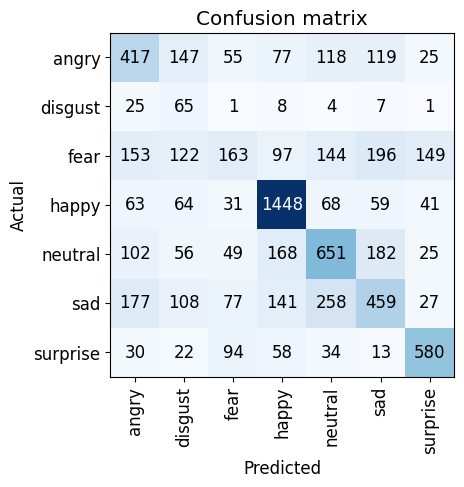

In [ ]:
#Confusion matrix for the model
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

4.2 Evaluating the 'pretrained' model

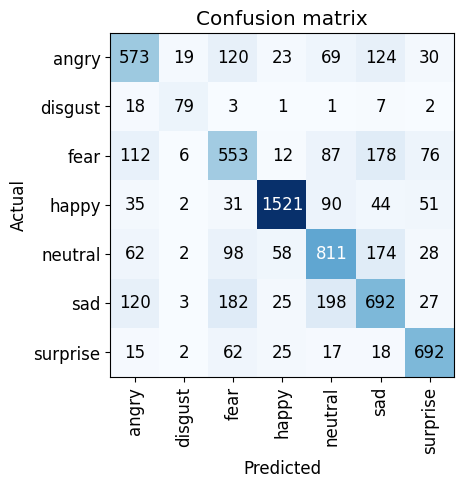

In [ ]:
#Confusion matrix for the model
interp = ClassificationInterpretation.from_learner(learn2)
interp.plot_confusion_matrix()

5.1 Saving the best performing model

In [ ]:
#Save the model to disk
learn2.export('/content/emotion_model.pkl')
